# Causal Inference

Impact on the bitcoin stock value after PayPal announced the users can buy and sell crypto currency on their app

For more info: https://newsroom.paypal-corp.com/2020-10-21-PayPal-Launches-New-Service-Enabling-Users-to-Buy-Hold-and-Sell-Cryptocurrency

# Libraries 

In [1]:
import yfinance as yf
from causalimpact import CausalImpact
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Setting the training and treatment dates

The dates used must be business days

In [2]:
training_start = "2020-09-25"  # at least a month before the impact day
training_end = "2020-10-19"  # day before the impact

treatment_start = "2020-10-21"  # impact day
treatment_end = "2020-10-23"  # small period after the impact

end_stock = "2020-10-24"  # a day after the treatment end

# Loading the financial data

In [3]:
# target variable
y = ["BTC-USD"]

y = yf.download(
    tickers=y,  # target variable
    start=training_start,  # training start
    end=end_stock,  # last day of our observation
    interval="1d",  # interval
)  

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


When doing causal inference (especially in time series or financial contexts), we often use 'Close' because it typically represents the closing price of a stock, commodity, or asset the final traded price of the day.

In [4]:
y = y["Close"]
y[:4]

Ticker,BTC-USD
Date,
2020-09-25,10692.716797
2020-09-26,10750.723633
2020-09-27,10775.269531
2020-09-28,10709.652344


# Load more financial data:

To model a proper control group, we include additional stocks from diverse sectors. The goal is to select companies that are unlikely to be directly affected by PayPal's cryptocurrency initiative, and whose stock prices are not causally impacted by changes in Bitcoin's value.

By doing so, we aim to account for broader market trends and macroeconomic movements that could affect all stocks - isolating the specific impact of the PayPal event on Bitcoin. These control stocks serve as a proxy for the market environment, helping us block potential confounding paths without introducing post-treatment bias.

In [5]:
# Load more data
stocks = ["MSTR", "RIOT", "MARA", "HUT", "BITF", "GBTC"]
X = yf.download(tickers=stocks, 
                start=training_start, 
                end=end_stock, 
                interval="1d")


[*********************100%***********************]  6 of 6 completed


# Data prep

In [6]:
X = X.iloc[:, : len(stocks)]
X.head()

Price       Close                                  
Ticker       BITF   GBTC    HUT  MARA    MSTR  RIOT
Date                                               
2020-09-25  0.259  11.23  3.500  1.93  14.613  2.68
2020-09-28  0.250  11.16  3.750  2.02  15.146  2.74
2020-09-29  0.255  11.03  3.650  2.02  14.969  2.76
2020-09-30  0.240  10.97  3.700  1.96  15.056  2.70
2020-10-01  0.240  10.87  3.585  1.95  14.896  2.65

In [7]:
# removing level

X.columns = X.columns.droplevel()
X.head()

Ticker,BITF,GBTC,HUT,MARA,MSTR,RIOT
Date,,,,,,
2020-09-25,0.259,11.23,3.500,1.93,14.613,2.68
2020-09-28,0.250,11.16,3.750,2.02,15.146,2.74
2020-09-29,0.255,11.03,3.650,2.02,14.969,2.76
2020-09-30,0.240,10.97,3.700,1.96,15.056,2.70
2020-10-01,0.240,10.87,3.585,1.95,14.896,2.65


In [8]:
# remove time zones
X.index = X.index.tz_localize(None)
X.index

DatetimeIndex(['2020-09-25', '2020-09-28', '2020-09-29', '2020-09-30',
               '2020-10-01', '2020-10-02', '2020-10-05', '2020-10-06',
               '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-12',
               '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16',
               '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22',
               '2020-10-23'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [9]:
# Combine bitcoin data and the 
df = pd.concat([y, X], axis=1).dropna()
df.head()

Ticker,BTC-USD,BITF,GBTC,HUT,MARA,MSTR,RIOT
Date,,,,,,,
2020-09-25,10692.716797,0.259,11.23,3.500,1.93,14.613,2.68
2020-09-28,10709.652344,0.250,11.16,3.750,2.02,15.146,2.74
2020-09-29,10844.640625,0.255,11.03,3.650,2.02,14.969,2.76
2020-09-30,10784.491211,0.240,10.97,3.700,1.96,15.056,2.70
2020-10-01,10619.452148,0.240,10.87,3.585,1.95,14.896,2.65


# Data Analysis

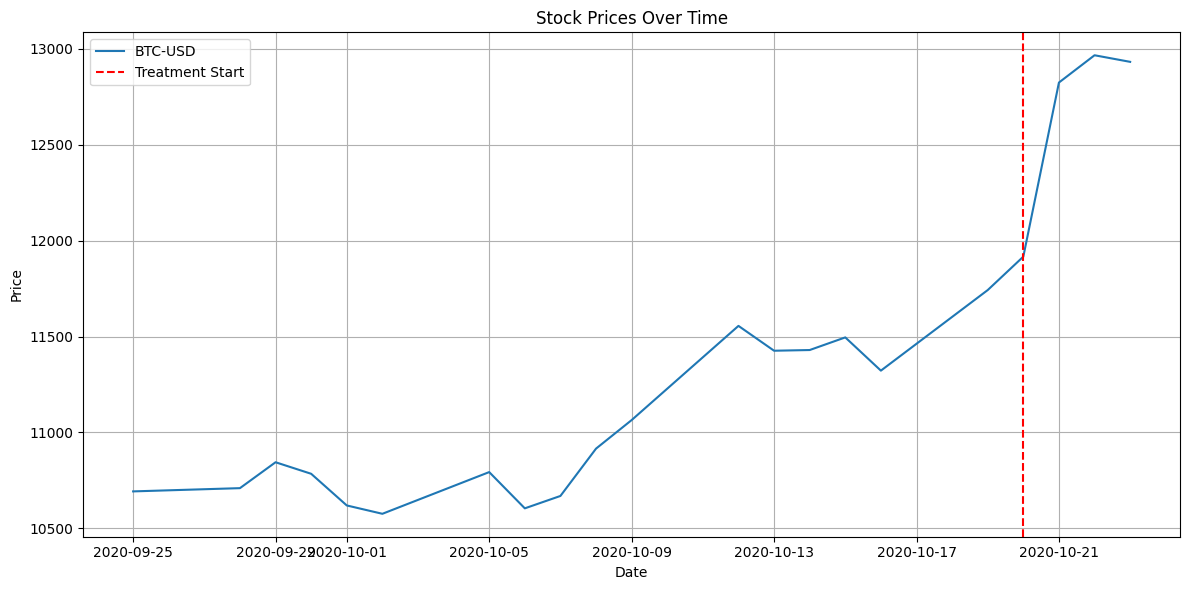

In [10]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BTC-USD'], label='BTC-USD')

treat_start_dt = pd.to_datetime("2020-10-20")
plt.axvline(treat_start_dt, color='red', linestyle='--', label='Treatment Start')

plt.title("Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

There is an increase in stock price after the announcement but there was a positive trend to begin with 

# Stationarity

A time series is stationary if its statistical properties (mean, variance, autocorrelation) do not change over time.

In [11]:
result = adfuller(df['BTC-USD'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 2.0141754423148654
p-value: 0.998691089914445


The time series is not stationary, therefore apply differencing

In [12]:
# Differencing 
df = df.pct_change().dropna()
df.head(2)

Ticker,BTC-USD,BITF,GBTC,HUT,MARA,MSTR,RIOT
Date,,,,,,,
2020-09-28,0.001584,-0.034749,-0.006233,0.071429,0.046632,0.036474,0.022388
2020-09-29,0.012604,0.020000,-0.011649,-0.026667,0.000000,-0.011686,0.007299


In [13]:
result = adfuller(df['BTC-USD'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.095791903250636
p-value: 0.000984153245606568


after the differencing the time series is stationary

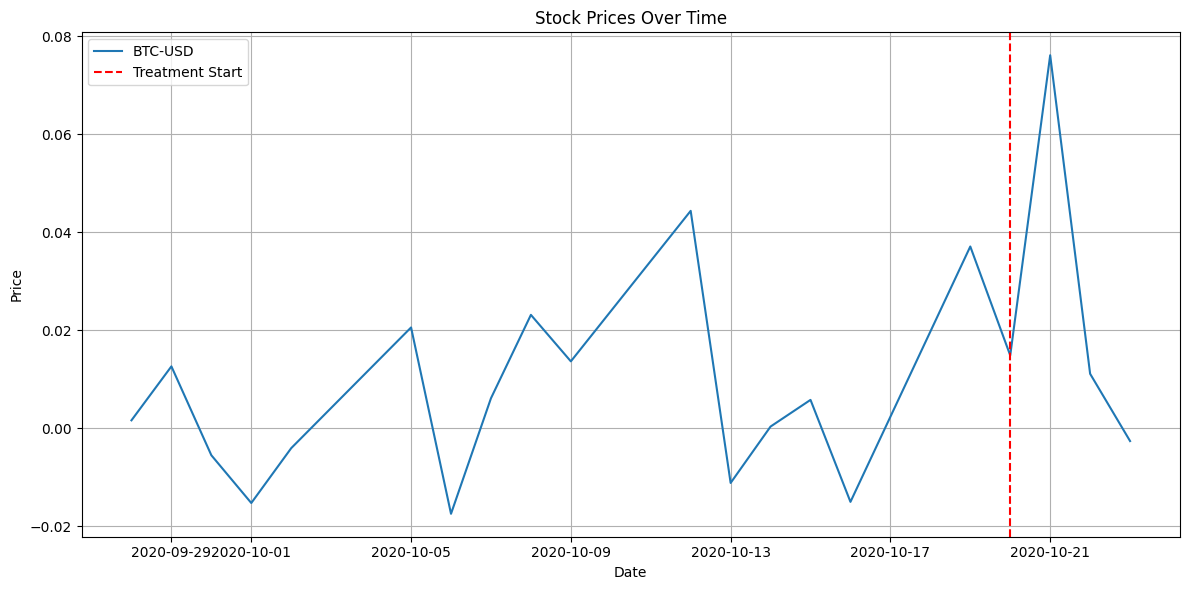

In [20]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BTC-USD'], label='BTC-USD')

treat_start_dt = pd.to_datetime("2020-10-20")
plt.axvline(treat_start_dt, color='red', linestyle='--', label='Treatment Start')

plt.title("Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation Matrix

<Axes: xlabel='Ticker', ylabel='Ticker'>

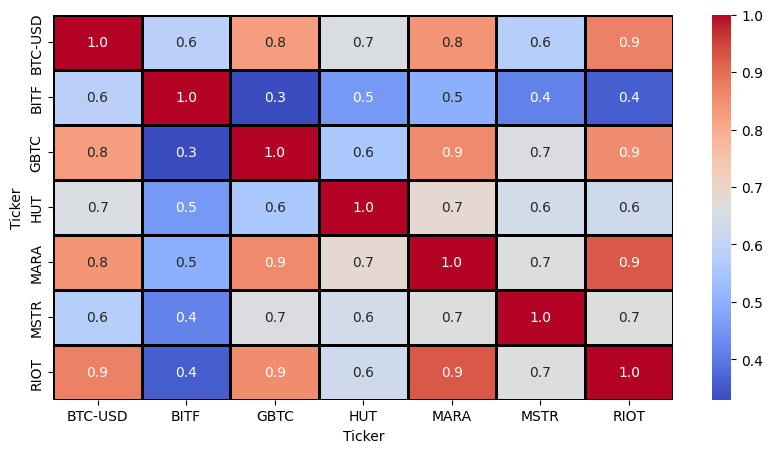

In [15]:
# Correlation matrix in stationary data

plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(),
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            linecolor='black',
            linewidths=1)

All of our columns have a positive correlation with the target so we will keep them, if any correaltion went under 0.3 remove them

# Causal Impact

## Pre and post period 

In [16]:
training_start = df.index[0]
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

## Causal Graph

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


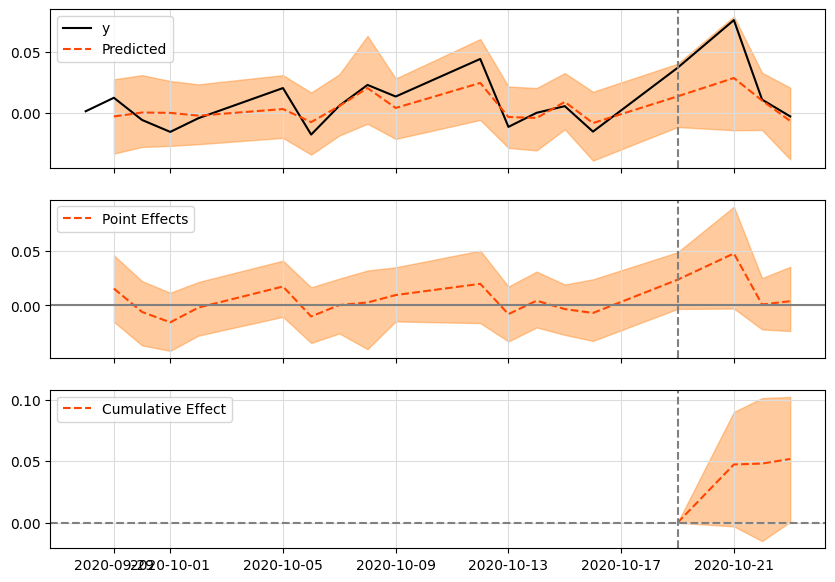

In [17]:
impact = CausalImpact(data=df,
                     pre_period=pre_period,
                     post_period=post_period)
impact.plot()

## Causal Inference Summary

In [18]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.03               0.08
Prediction (s.d.)         0.01 (0.01)        0.03 (0.03)
95% CI                    [-0.01, 0.03]      [-0.02, 0.09]

Absolute effect (s.d.)    0.02 (0.01)        0.05 (0.03)
95% CI                    [-0.0, 0.04]       [-0.0, 0.11]

Relative effect (s.d.)    158.31% (85.53%)   158.31% (85.53%)
95% CI                    [-10.14%, 325.12%] [-10.14%, 325.12%]

Posterior tail-area probability p: 0.03
Posterior prob. of a causal effect: 96.8%

For more details run the command: print(impact.summary('report'))


We can print the model summary report

In [19]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.03. In the absence of an
intervention, we would have expected an average response of 0.01.
The 95% interval of this counterfactual prediction is [-0.01, 0.03].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.02 with a 95% interval of
[-0.0, 0.04]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 0.08.
Had the intervention not taken place, we would have expected
a sum of 0.03. The 95% interval of this prediction is [-0.02, 0.09].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +158.31%. The 